# ETL Transformation Notebook

## Libraries

In [54]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

## Load extracted Data

In [55]:
rawData = pd.read_csv('data/raw_data.csv')
incrementalData = pd.read_csv('data/incremental_data.csv')
print(f"Loaded {len(rawData)} raw records and {len(incrementalData)} incremental records")


Loaded 100 raw records and 10 incremental records


## Transfromation 1: Cleaning missing values

#### Before Cleaning

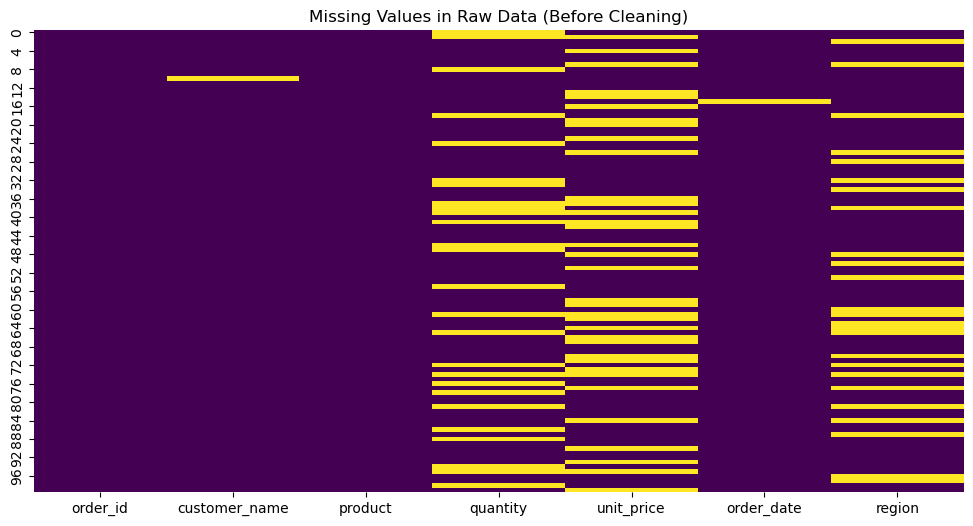

In [56]:
plt.figure(figsize=(12, 6))
sns.heatmap(rawData.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values in Raw Data (Before Cleaning)')
plt.show()

#### Creating compies for Transformation

In [57]:
rawCleaned = rawData.copy()
incCleaned = incrementalData.copy()

#### Before cleaning

In [58]:
print(f"Raw data - Missing values: {rawData.isnull().sum().sum()}")
print(f"Raw data - Duplicates: {rawData.duplicated().sum()}")
print(f"Incremental data - Missing values: {incrementalData.isnull().sum().sum()}")


Raw data - Missing values: 88
Raw data - Duplicates: 1
Incremental data - Missing values: 12


#### Missing cutomer names
- change the missing names to Unknown for both raw and incremental

In [59]:
rawCleaned['customer_name'].fillna('Unknown_Customer', inplace=True)
incCleaned['customer_name'].fillna('Unknown_Customer', inplace=True)

#### Imputing missing quantities for raw data using median
- this is beacause median values are less affected by outliers
- calculates the median of the quantity column and fills missing values with it

In [60]:
for product in rawCleaned['product'].unique():
    product_median_qty = rawCleaned[rawCleaned['product'] == product]['quantity'].median()
    rawCleaned.loc[(rawCleaned['product'] == product) & (rawCleaned['quantity'].isna()), 'quantity'] = product_median_qty


#### Imputing missing values for incremental data using median 
- used the same logic as above
- calculates the median of the quantity column and fills missing values with it

In [61]:
for product in incCleaned['product'].unique():
    product_median_qty = incCleaned[incCleaned['product'] == product]['quantity'].median()
    incCleaned.loc[(incCleaned['product'] == product) & (incCleaned['quantity'].isna()), 'quantity'] = product_median_qty

#### missing unit prices using median
- first created a price mapping dictionary to hold the median prices for each product
- used the apply() logic to replace missing unit prices with the median price for that product

In [62]:
price_map = rawCleaned.groupby('product')['unit_price'].median().to_dict()
rawCleaned['unit_price'] = rawCleaned.apply(
    lambda row: price_map[row['product']] if pd.isna(row['unit_price']) else row['unit_price'], 
    axis=1
)

#### Missing regions
- created most common region mapping dictionary using the mode() function
- used the fillna() function to replace missing regions with the most common region for that product
- applied this to both raw and incremental data

In [63]:
# Create mapping
region_map = rawCleaned.dropna().groupby('customer_name')['region'].agg(lambda x: x.mode()[0] if not x.mode().empty else 'Unknown').to_dict()
# Fill missing regions
rawCleaned['region'] = rawCleaned['region'].fillna(rawCleaned['customer_name'].map(region_map)).fillna('Unknown')
incCleaned['region'] = incCleaned['region'].fillna('Central')

#### Removing Exact Duplicates
- using the drop_duplicates() function to remove exact duplicates from both raw and incremental data

In [64]:
rawCleaned.drop_duplicates(inplace=True)
incCleaned.drop_duplicates(inplace=True)

#### Cleaning verification
- This is to check the missing values after cleaning

In [65]:
print(f"Raw data - Missing values: {rawCleaned.isnull().sum().sum()}")
print(f"Raw data - Duplicates: {rawCleaned.duplicated().sum()}")
print(f"Raw data - Records: {len(rawData)} → {len(rawCleaned)}")

Raw data - Missing values: 1
Raw data - Duplicates: 0
Raw data - Records: 100 → 99


#### Visualization after Cleaning

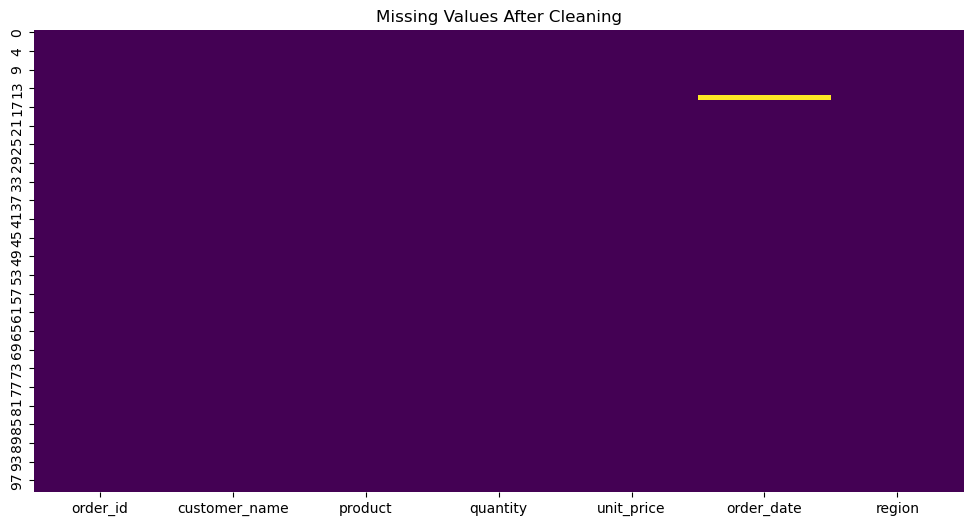

In [66]:
plt.figure(figsize=(12, 6))
sns.heatmap(rawCleaned.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values After Cleaning')
plt.show()

## Transfromation 2: Data Enrichment

#### Feature Engineering: Adding total price columns to botb raw and incremental data

In [67]:
rawCleaned['total_price'] = rawCleaned['quantity'] * rawCleaned['unit_price']
incCleaned['total_price'] = incCleaned['quantity'] * incCleaned['unit_price']

#### Adding a price ordering column, to sort prices from low to high, called it Price_range

In [68]:
def categorize_order_value(total_price):
    if pd.isna(total_price):
        return 'Unknown'
    elif total_price < 500:
        return 'Low'
    elif total_price < 1500:
        return 'Medium'
    else:
        return 'High'

rawCleaned['price_range'] = rawCleaned['total_price'].apply(categorize_order_value)
incCleaned['price_range'] = incCleaned['total_price'].apply(categorize_order_value)

## Transformation 3: Structural Changes

#### looking at Data-Types
- we can see order date is an object, which needs to change
- we need to change datatypes for standardization


In [69]:
print(rawData.dtypes)

order_id           int64
customer_name     object
product           object
quantity         float64
unit_price       float64
order_date        object
region            object
dtype: object


#### converting to Datetimes:

In [70]:
rawCleaned['order_date'] = pd.to_datetime(rawCleaned['order_date'])
incCleaned['order_date'] = pd.to_datetime(incCleaned['order_date'])

#### Timeseries Analysis
- Monthly sales trend now that we have the order date in datetime format

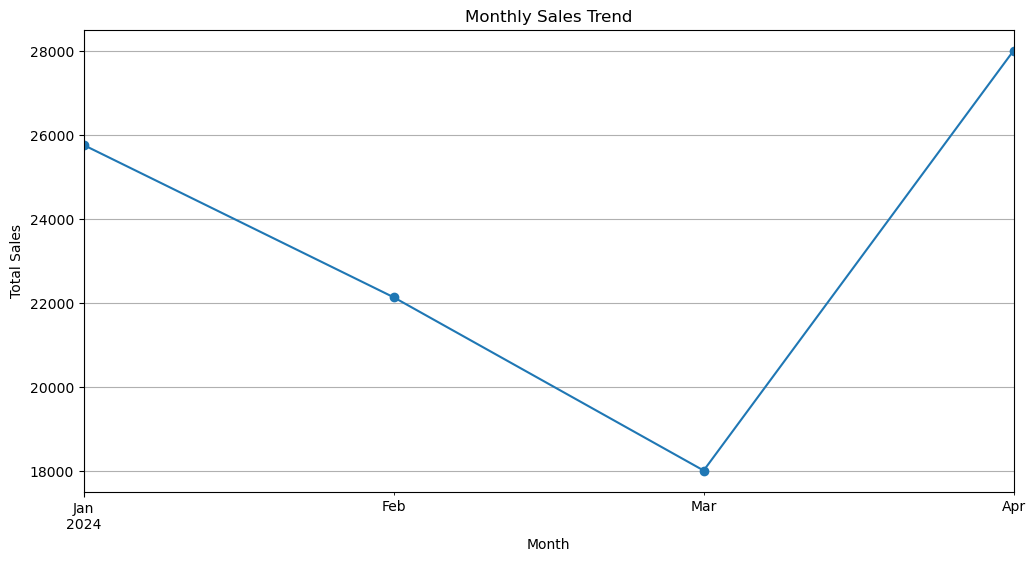

In [71]:
monthly_sales = rawCleaned.groupby(rawCleaned['order_date'].dt.to_period('M'))['total_price'].sum()
plt.figure(figsize=(12, 6))
monthly_sales.plot(kind='line', marker='o')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

#### Rounding off Numerical data to 2 decimal places
- this is done to standardize the data


In [72]:
rawCleaned['unit_price'] = rawCleaned['unit_price'].round(2)
rawCleaned['total_price'] = rawCleaned['total_price'].round(2)
incCleaned['unit_price'] = incCleaned['unit_price'].round(2)
incCleaned['total_price'] = incCleaned['total_price'].round(2)

#### Text Standardization
- removing whitespace
- capitalizing names
- capitalizing all region names

In [73]:
rawCleaned['customer_name'] = rawCleaned['customer_name'].str.strip().str.title()
rawCleaned['product'] = rawCleaned['product'].str.strip().str.title()
rawCleaned['region'] = rawCleaned['region'].str.strip().str.upper()

incCleaned['customer_name'] = incCleaned['customer_name'].str.strip().str.title()
incCleaned['product'] = incCleaned['product'].str.strip().str.title()
incCleaned['region'] = incCleaned['region'].str.strip().str.upper()

#### Verifying changes in cleaned data

In [74]:
print(rawCleaned.dtypes)

order_id                  int64
customer_name            object
product                  object
quantity                float64
unit_price              float64
order_date       datetime64[ns]
region                   object
total_price             float64
price_range              object
dtype: object


## Transformation 4: Filtering

#### Dropping irrelevant columns
- after looking at the data, i believe price range is unncecessary
- dropping price range

In [75]:
print("rawCleaned columns:", rawCleaned.columns.tolist())
rawCleaned = rawCleaned.drop(columns=['price_range'], errors='ignore')

rawCleaned columns: ['order_id', 'customer_name', 'product', 'quantity', 'unit_price', 'order_date', 'region', 'total_price', 'price_range']


#### Filtering Unealistic values

In [76]:
rawCleaned = rawCleaned[(rawCleaned['quantity'] > 0) & (rawCleaned['unit_price'] > 0)]
incCleaned = incCleaned[(incCleaned['quantity'] > 0) & (incCleaned['unit_price'] > 0)]

#### Checking the after of filtering

In [81]:
print(rawCleaned.info())
print(incCleaned.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99 entries, 0 to 99
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   order_id                  99 non-null     int64         
 1   customer_name             99 non-null     object        
 2   product                   99 non-null     object        
 3   quantity                  99 non-null     float64       
 4   unit_price                99 non-null     float64       
 5   order_date                98 non-null     datetime64[ns]
 6   region                    99 non-null     object        
 7   total_price               99 non-null     float64       
 8   region_group              99 non-null     object        
 9   customer_order_frequency  99 non-null     int64         
 10  customer_tier             99 non-null     object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(5)
memory usage: 9.3+ KB
None
<clas

## Transformation 5: Categorization

#### Region Categorization
- creating a region mapping dictionary to categorize regions to specify the nortrhern region, southern region, eastern region, and western region
- using the map() function to apply this mapping to the region column in both raw and incremental

In [77]:
region_groups = {
    'NORTH': 'Northern_Region',
    'SOUTH': 'Southern_Region',
    'EAST': 'Eastern_Region', 
    'WEST': 'Western_Region',
    'CENTRAL': 'Central_Region',
    'UNKNOWN': 'Unassigned'
}
rawCleaned['region_group'] = rawCleaned['region'].map(region_groups)
incCleaned['region_group'] = incCleaned['region'].map(region_groups)

#### Sales By region

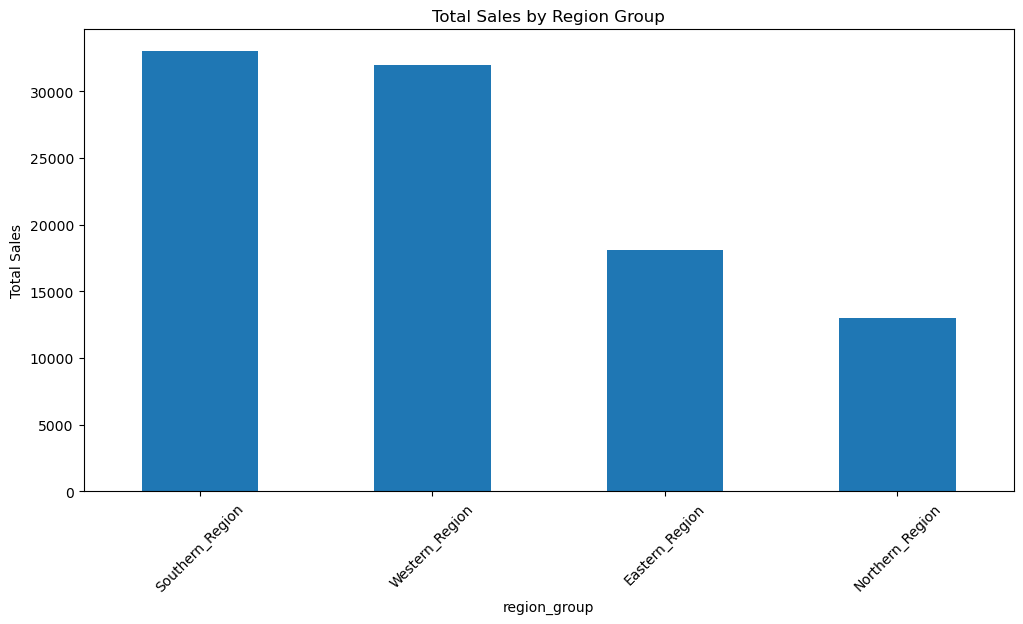

In [82]:
plt.figure(figsize=(12, 6))
region_sales = rawCleaned.groupby('region_group')['total_price'].sum().sort_values(ascending=False)
region_sales.plot(kind='bar')
plt.title('Total Sales by Region Group')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()

#### Customer Tiers

In [78]:
customer_order_counts = rawCleaned['customer_name'].value_counts().to_dict()
rawCleaned['customer_order_frequency'] = rawCleaned['customer_name'].map(customer_order_counts)

def categorize_customer_tier(frequency):
    if frequency >= 10:
        return 'VIP'
    elif frequency >= 5:
        return 'Loyal'
    elif frequency >= 2:
        return 'Regular'
    else:
        return 'New'

rawCleaned['customer_tier'] = rawCleaned['customer_order_frequency'].apply(categorize_customer_tier)


#### Customer Tier Distribution

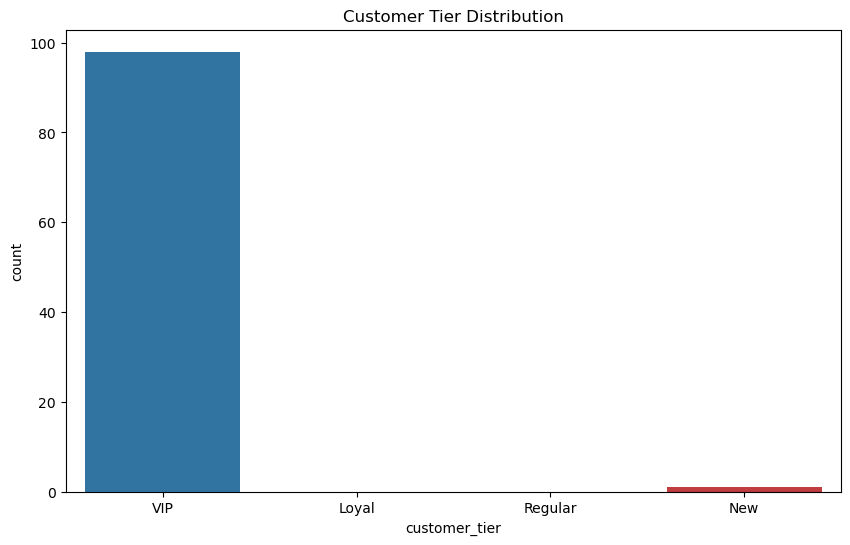

In [79]:
plt.figure(figsize=(10, 6))
sns.countplot(data=rawCleaned, x='customer_tier', 
              order=['VIP', 'Loyal', 'Regular', 'New'])
plt.title('Customer Tier Distribution')
plt.show()


- this shows that most customers are VIP
- need to reevaluate the customer tier distribution

## Saving Transformations

In [80]:
rawCleaned.to_csv('transformed/transformed_full.csv', index=False)
incCleaned.to_csv('transformed/transformed_incremental.csv', index=False)